In [1]:
# import libraries used in this notebook
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import spacy
import en_core_web_sm
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
%matplotlib inline

c:\Users\Anike\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Anike\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\Anike\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Introduction

<center>
    <img src = "images/cfpb logo.png"  />
</center>

The CFPB dataset is a collection of complaints filed by consumers against financial institutions. The dataset contains a number of features, including the text of the complaint, the product type, and the company the complaint was filed against. The full dataset is available at https://www.consumerfinance.gov/data-research/consumer-complaints/. This dataset is convenient for text analysis because the consumer complaints are real text generated by real people - and have all the idiosyncrasies that come with that process. It also contains multiple different categories that we can predict, like type of product the complaint is about and whether the complaint was resolved quickly. The basic process is that if someone has a dispute related to consumer finance (mortgages, student loans, credit cards, etc.), they can file a dispute with the CFPB, which then contacts the company named in the dispute to get some resolution of the issue.

We will use this dataset to explore the entire text analysis and machine learning pipeline. Specifically we will:

1. Represent text as tokens and matrices to prepare them for machine learning
2. Engineer additional text features like topic codes and sentiments with unsupervised learning techniques
3. Use Supervised Learning to predict the "Product" category based on the text

Notice how this notebook is full of comments. Much of the code here was generated with Github CoPilot! If you enjoy using ChatGPT to generate code, consider integrating it directly into your notebooks with this tool.

In [2]:
## load 2023 complaints data from data folder as CFPB_2023
cfpb = pd.read_csv('data/CFPB Complaints 2023.csv')

# Drop observations with missing data in the 'Consumer complaint narrative' column and reset index
cfpb = cfpb.dropna(subset=['Consumer complaint narrative']).reset_index(drop=True)

# look at the first 5 rows of cfpb
cfpb.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_received
0,13,2023-07-22,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,Money is being held with out my permission. Ca...,NaN,Chime Financial Inc,CA,95678,NaN,Consent provided,Web,2023-07-22,Closed with explanation,Yes,NaN,7291298,2023
1,19,2023-07-22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I do not have any knowledge of applying for a ...,Company has responded to the consumer and the ...,SYNCHRONY FINANCIAL,AZ,85741,NaN,Consent provided,Web,2023-07-22,Closed with non-monetary relief,Yes,NaN,7291403,2023
2,24,2023-08-29,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,"Seriously, it's been months since I investigat...",Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NJ,07087,NaN,Consent provided,Web,2023-08-29,Closed with non-monetary relief,Yes,NaN,7460791,2023
3,36,2023-08-29,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Investigation took more than 30 days,I have been trying to dispute incorrect and/or...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85013,NaN,Consent provided,Web,2023-08-29,Closed with non-monetary relief,Yes,NaN,7463275,2023
4,48,2023-07-17,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Received unwanted marketing or advertising,It shows that a mortgage company pulled my cre...,NaN,"EQUIFAX, INC.",NC,27292,NaN,Consent provided,Web,2023-07-17,Closed with explanation,Yes,NaN,7264416,2023


In [3]:
# Show some descriptive statistics for the product, issue, company response to consumer, timely response, and consumer disputed columns, but ignore NAs in each column
cfpb[['Product', 'Issue', 'Company response to consumer', 'Timely response?']].describe()

,Product,Issue,Company response to consumer,Timely response?
count,298530,298530,298530,298530
unique,14,85,5,2
top,"Credit reporting, credit repair services, or o...",Incorrect information on your report,Closed with explanation,Yes
freq,211354,84770,185752,296878


In [4]:
# Check the first 10 rows of the consumer complaint narrative column and print the full text of each with a number next to each complaint
for i in range(10):
    print(i, cfpb['Consumer complaint narrative'][i])

0 Money is being held with out my permission. Causing me to have pain and suffering for me and my daughter. Horrible customer service and rude employees lie about the policy and does not follow it. I am having a horrible experience with chime and it needs to be resolved.
1 I do not have any knowledge of applying for a credit card with XXXX. Nor do I have a contract with the debt collector. I demand this inquiry be removed from my credit report.
2 Seriously, it's been months since I investigated my credit report, and I realized that some of the information was still erroneous. The 3 credit bureaus are required to authenticate these items under Sections 609 ( a ) ( 1 ) ( A ) and 611 ( a ) ( 1 ). ( A ). It is not acceptable to treat these reporting items as unconfirmed information without producing proof within the legal time range. Sections 609 ( a ) ( 1 ) ( A ) and 611 ( a ) ( 1 ). ( A ), Please investigate the unverifiable items and remove them immediately from my report XXXX XXXX XXXX

In [5]:
# Subset cfpb so that Product is one of 'Money transfer, virtual currency, or money service' or 'Vehicle loan or lease
cfpb = cfpb[cfpb['Product'].isin(['Debt collection', 'Credit card or prepaid card'])].reset_index(drop=True)
cfpb['Product'].value_counts()

Debt collection                22309
Credit card or prepaid card    19948
Name: Product, dtype: int64

<center>
    <img src = "images/ml_workflow.png"  />
</center>

The typical machine learning workflow involves data collection, processing, training models, testing models, and deploying models. We took care of the data collection part, and now will focus on some techniques for cleaning, training, and evaluating machine learning models for text analysis.

# Step 1: Text Featurization Using spaCy

Text needs to be represented numerically before it can be used in a machine learning pipeline. We will cover some of the basic building blocks for:

1. Representing text as "tokens"
2. Creating matrices that count and scale how often words occur in a corpus of text

## 1.1 Stemming, Lemmatization, and Chunking

#### 1.1.1 Tokenization

The basic unit of analysis in text analysis is the **token**, which is a numerical representation of text. Imagine we are trying to build a puzzle. Each "token" represents a piece of the puzzle, and can correspond to different sizes (like paragraphs, sentences, or words). 

Let's see how we tokenize in practice. spaCy uses pre-trained language models to incorporate context when creating tokens. In this case, we'll load the [en_core_web_sm](https://spacy.io/models/en), which is one of spaCy's English language models. 

Consider the sentence: "Last year, the average cost of a coffee cup in the U.S.A $5.89." Splitting on punctuation would yield a token list like:

[Last, year, the, average, cost, of, a, coffee, cup, in, the, U, S, A, was, $5, 89]

Most of these tokens look pretty good, but we get some errors like splitting "USA" into three separate tokens and spltting $5.89 into $5 and 89. 

spaCy helps [solve this problem](https://spacy.io/usage/spacy-101#annotations-token) by going through the following steps:

First, the raw text is split on whitespace characters, similar to `text.split(' ')`. Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

1. Does the substring match a tokenizer exception rule? For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.S.A” should always remain one token.
2. Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.

If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

Now let's try applying these methods to our CFPB data. The steps to do this are:

1. Load the language model.
2. Apply it to a piece of text and save it in an spaCy "doc" object.
3. Extract each token from the doc object to a list.
4. Display the tokens

Let's do this for our first observation in our dataframe:

In [6]:
# save the first cfpb consumer complaint as "text"
text = cfpb['Consumer complaint narrative'][0]

# load the spaCy language model
nlp = en_core_web_sm.load()

# Apply it to a piece of text and save it in a spaCy "doc" object
doc = nlp(text)

# Extract each token from the doc object to a list
spacy_words = [token.text for token in doc]

# Display the tokens
display(f"Tokenized words: {spacy_words}")

"Tokenized words: ['Money', 'is', 'being', 'held', 'with', 'out', 'my', 'permission', '.', 'Causing', 'me', 'to', 'have', 'pain', 'and', 'suffering', 'for', 'me', 'and', 'my', 'daughter', '.', 'Horrible', 'customer', 'service', 'and', 'rude', 'employees', 'lie', 'about', 'the', 'policy', 'and', 'does', 'not', 'follow', 'it', '.', 'I', 'am', 'having', 'a', 'horrible', 'experience', 'with', 'chime', 'and', 'it', 'needs', 'to', 'be', 'resolved', '.']"

### 1.1.2 Removing Stop Words and Punctuation

We now have some tokens with just a few lines of code! There are a few additional steps that we might want to take. For example, we may want to remove punctuation and stop words. Punctuation oftentimes does not add substantive information to a piece of text, and stop words are common words that appear very frequently across texts. Removing this kind of information can help with downstream classification tasks by allowing an algorithm to focus on words that distinguish documents, rather than ones that appear frequently across them. 

First, let's take a look at stop words. We can start by importing a collection of stop words from spaCy by running the following code:

In [7]:
# import stop words and look at the 10 most common ones
from spacy.lang.en.stop_words import STOP_WORDS
print(list(STOP_WORDS)[0:10])

['such', 'were', 'go', "'s", 'yourself', 'these', 'along', 'latterly', 'empty', 'seemed']


We can do the same for punctuation:

In [8]:
# import punctuation
from string import punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Removing punctuation and stop words is not a hard and fast rule - there may be situations where you want to keep them. In most applications, they add noise to downstream tasks, but always be mindful of your particular application when making decisions. Now that we have some tokenization tools, let's put them all together in a function!

#### Challenge: Write a function that takes a piece of text as an argument, and returns a list of tokens without punctuation or stop words.

In [9]:
# Write a function, with comments, `rem_punc_stop` that takes the argument `text` and returns a list of tokens that are free of punctuation and stop words.
def rem_punc_stop(text):
    # create a spaCy doc object
    doc = nlp(text)
    # create a list of tokens from the doc object
    tokens = [token.text for token in doc]
    # create a list of tokens that are not stop words or punctuation
    tokens_reduced = [token for token in tokens if (token not in STOP_WORDS) and (token not in punctuation)]
    # return the list of tokens
    return tokens_reduced


# test rem_punc_stop with the text from the first cfpb complaint and save the result in tokens_reduced
tokens_reduced = rem_punc_stop(text)
tokens_reduced[0:10]

['Money',
 'held',
 'permission',
 'Causing',
 'pain',
 'suffering',
 'daughter',
 'Horrible',
 'customer',
 'service']

### 1.1.3 Lemmatization

Another preprocessing step we might take is reducing words down to their lemmas. Lemmatization reduces a word to its root word, while making sure the word still belongs to the language. Consider the following example:

In [10]:
# write code that goes through the string 'compute computer computed computing' and prints the text and lemma
doc = nlp('compute computer computed computing')
for token in doc:
    print(token.text, token.lemma_)

compute compute
computer computer
computed compute
computing computing


### Bag of Words/Tf-idf

How do we go from tokens to making predictions with text? Supervised machine learning applications will generally have a `target` to be predicted and `features` used to make that prediction. These are the equivalents of the `dependent variable`/`response variable`/`outcome` and `independent variables`/`explanatory variables`/`covariates` in machine learning terms. There are many options for converting raw text into `features`. We will start with **bag of words**, one of the simplest ways to represent tokens as counts. Consider the following toy example:

| Product                        | money | harass | social | Visa | credit |
|--------------------------------|-------|--------|--------|------|--------|
| Debt or Debt Collection        | 5     | 7      | 2      | 0    | 4      |
| Credit card or prepaid card    | 3     | 1      | 3      | 5    | 6      |
| Credit card or prepaid card    | 4     | 0      | 1      | 0    | 3      |
| Debt or Debt Collection        | 2     | 1      | 0      | 0    | 2      |
| Debt or Debt Collection        | 1     | 2      | 3      | 0    | 1      |


In this data, each row is a separate consumer complaint. *Product* is the target we want to predict, and each column represents a token. Each cell represents how many times that token appears in that document.

Let's see how we do this with code. We'll import the CounterVectorizer method from sklearn, then use the tokenizer function that we wrote earlier to initialize the CountVectorizer.

In [11]:
# initialize CounterVectorizer then use rem_punc_stop as the tokenizer and save as bow_vector
bow_vector = CountVectorizer(tokenizer=rem_punc_stop)

Once we create a CountVectorizer object, we can then transform a list of texts with the "fit_transform" method. This will return a sparse matrix with the counts. We can densify the matrix (store non-zero values and their positions) with the ".todense()" method.

In [12]:
# fit bow_vector to the first 5 complaints in cfpb['Consumer complaint narrative'] and save as bow_matrix
bow_matrix = bow_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

c:\Users\Anike\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
# densify bow_matrix and save as bow_matrix_dense
bow_matrix_dense = bow_matrix.todense()
bow_matrix_dense

matrix([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  1,  0,  0],
        [ 0,  0,  3, ..., 13,  1,  1],
        [ 0,  1,  0, ...,  3,  0,  0],
        [ 1,  0,  0, ..., 10,  0,  0]], dtype=int64)

We can also get the feature names:

In [14]:
# get the feature names from bow_vector and print the first 50
feature_names = bow_vector.get_feature_names_out()
feature_names[0:50]

array(['\n', '\n\n', ' ', '1', '10', '100', '2300.00', '460.00', '5',
       '890.00', 'account', 'additional', 'admitted', 'advise',
       'affected', 'agency', 'aggressively', 'aging', 'agreed', 'america',
       'apologetically', 'apologized', 'approached', 'asked', 'asking',
       'assist', 'association', 'assured', 'attempted', 'auto', 'away',
       'balance', 'bank', 'behalf', 'believe', 'belligerent', 'berated',
       'better', 'bill', 'boa', 'brought', 'bureau', 'business', 'called',
       'car', 'card', 'causing', 'certainly', 'change', 'charge'],
      dtype=object)

### Term Frequency - Inverse Document Frequency

An extension of bag-of-words is the term frequency-inverse document frequency approach. Whereas bag-of-words counts the number of words in the document. tf-idf takes this quanity and divides it by how frequently the word shows up across the corpus. In notation:

$TF-IDF(t,d)=TF(t,d)×IDF(t)$

Where:

* $TF(t,d)$ is term frequency of term $t$ in document $d$ (number of times a token appears in that consumer complaint)
* $IDF(f) = log(\frac{N}{DF(t)}$ is the inverse document frequency (where $N$ is number of documents, $DF(t)$ is the number of documents containing term $t$). (Log of number of consumer complaints/number of consumer complaints containing a token)

In doing so, the tf-idf score downweights words that are common in the corpus and thus would not aid with classification. Our toy example from before would look like this:

| Product      | money |   harass |   social |     Visa | credit |
|-------|-------|----------|----------|----------|--------|
| Debt or Debt Collection |   0.0 | 1.562005 | 0.446287 |  0.00000 |    0.0 |
| Credit card or prepaid card |   0.0 | 0.223144 | 0.669431 |  8.04719 |    0.0 |
| Credit card or prepaid card |   0.0 | 0.000000 | 0.223144 |  0.00000 |    0.0 |
| Debt or Debt Collection |   0.0 | 0.223144 | 0.000000 |  0.00000 |    0.0 |
| Debt or Debt Collection |   0.0 | 0.446287 | 0.669431 |  0.00000 |    0.0 |


**Challenge: Using the code from the "Bag of Words" section as a template, write code to get the tf-idf matrix for the CFPB data.**

In [15]:
# initialize TfidfVectorizer then use rem_punc_stop as the tokenizer and save as tfidf_vector
tfidf_vector = TfidfVectorizer(tokenizer=rem_punc_stop)

# fit tfidf_vector to the first 5 complaints in cfpb['Consumer complaint narrative'] and save as tfidf_matrix
tfidf_matrix = tfidf_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

# get the feature names from tfidf_vector, make a dataframe with the features names and tf-idf counts, and show the first 50 columns
feature_names = tfidf_vector.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=feature_names)
tfidf_df.iloc[:, 0:50]

,\n,\n\n,,1,10,100,2300.00,460.00,5,890.00,...,brought,bureau,business,called,car,card,causing,certainly,change,charge
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.211753,0.000000,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.054297,0.054297,0.000000,0.00000,0.054297,0.054297,0.00000,...,0.108594,0.043806,0.054297,0.00000,0.054297,0.175225,0.000000,0.000000,0.108594,0.054297
2,0.000000,0.00000,0.182822,0.000000,0.000000,0.121882,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.049167,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.10469,0.000000,0.000000,0.000000,0.000000,0.10469,0.000000,0.000000,0.10469,...,0.000000,0.000000,0.000000,0.10469,0.000000,0.084464,0.000000,0.000000,0.000000,0.000000
4,0.108176,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.108176,0.000000,0.000000


# Step 2: Feature Engineering

What if we want features that capture more information than just word counts? We will explore a few options for doing this:

1. Topic Models
2. Sentiment Analysis

## Topic Models

Machine learning can be divided into `supervised learning` or `unsupervised learning`. Supervised learning uses labeled data to map inputs to outputs (e.g. predict a Product category based on features in the CFPB dataset), whereas unsupervised learning finds patterns in unlabeled data (e.g. finds geographic clusters of "medical debt" complaints in the CFPB dataset).

One popular unsupervised method for text is the [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation), or topic modeling. Topic models can help us uncover structure within a text. Specifically it does so through a "mixture model" - meaning every document is assumed to be "about" various topics, and we try to estimate the proportion each topic contributes to a document.

Let's apply a LDA model. The key hyperparameter here is the `n_components` argument. Let's start with 5, and then print out our topics to see what we get.

In [16]:
# initialize LatentDirichletAllocation with 5 topics, 20 iterations, and a random state of 0, then fit it to tfidf_matrix
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(tfidf_matrix)

In [17]:
# print the top 10 words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic 0:
xxxx debt contacted work shop xx financial patient reached refund
Topic 1:
xxxx xx debt credit net closed opened reporting report account
Topic 2:
sent account xx balance told service follow proof xxxx problem
Topic 3:
payment saying received posted date provide milestone confirmation xxxx sent
Topic 4:
horrible daughter resolved policy permission pain suffering needs money rude


## Topic weights

One thing we may want to do with the output is compare the prevalence of each topic across documents. A simple way to do this, is to merge the topic distribution back into the Pandas dataframe.

First get the topic distribution array.

In [18]:
# Find the distribution of each topic across documents by merging the topic distribution into the original cfpb dataframe and call it cfpb_topics
topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist, columns=[f"topic_{i}" for i in range(5)])
cfpb_topics = topic_dist_df.join(cfpb.reset_index())
cfpb_topics.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,index,Unnamed: 0,Date received,Product,Sub-product,...,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_received
0,0.037337,0.037338,0.037343,0.037337,0.850645,0,13,2023-07-22,Credit card or prepaid card,General-purpose credit card or charge card,...,95678,NaN,Consent provided,Web,2023-07-22,Closed with explanation,Yes,NaN,7291298,2023
1,0.928547,0.017873,0.017859,0.017875,0.017846,1,135,2023-08-12,Credit card or prepaid card,General-purpose credit card or charge card,...,33325,NaN,Consent provided,Web,2023-08-12,Closed with explanation,Yes,NaN,7389759,2023
2,0.888354,0.028043,0.027830,0.027896,0.027877,2,200,2023-07-20,Debt collection,Medical debt,...,498XX,NaN,Consent provided,Web,2023-07-20,Closed with non-monetary relief,Yes,NaN,7279944,2023
3,0.030647,0.030686,0.030409,0.877859,0.030400,3,224,2023-07-17,Debt collection,Credit card debt,...,67212,NaN,Consent provided,Web,2023-07-17,Closed with explanation,Yes,NaN,7261717,2023
4,0.038024,0.848590,0.037771,0.037852,0.037763,4,227,2023-07-21,Debt collection,Payday loan debt,...,30236,NaN,Consent provided,Web,2023-07-21,Closed with explanation,Yes,NaN,7286377,2023


Now we can check the average weight of each topic across Product using `groupby`.

In [19]:
# check the average weight of each topic across Product by using groupby
grouped = cfpb_topics.groupby('Product')
for i in range(0, 5):
    print(grouped[f"topic_{i}"].mean().sort_values(ascending=False))

Product
Credit card or prepaid card    0.482942
Debt collection                0.319009
Name: topic_0, dtype: float64
Product
Debt collection                0.302440
Credit card or prepaid card    0.027605
Name: topic_1, dtype: float64
Product
Debt collection                0.032003
Credit card or prepaid card    0.027601
Name: topic_2, dtype: float64
Product
Debt collection                0.314535
Credit card or prepaid card    0.027606
Name: topic_3, dtype: float64
Product
Credit card or prepaid card    0.434246
Debt collection                0.032013
Name: topic_4, dtype: float64


Topics 2 and 3 seem to have a lot of separation between checkings or savings account and student loans. Let's plot them:

### Sentiment Polarity

A common area of research in the social sciences is thinking about the "sentiment" of a text. The [`TextBlob`](https://textblob.readthedocs.io/en/dev/quickstart.html) library gives us access to a pre-trained sentiment analysis model. Text might be characterized as "positive," "negative," or "neutral" on a [-1,1] scale with -1 being highly negative and 1 being highly positive. Before we look at the code, do you expect that the sentiment scores for these data should be negative or positive? 

In [20]:
# take cfpb, take just the first 5 rows and call cfpb_sample, create a column ['tokens'] that uses rem_punc_stop to tokenize, join the list of tokens
cfpb_sample = cfpb[0:5]
cfpb_sample['tokens'] = cfpb_sample['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
cfpb_sample['tokens'] = cfpb_sample['tokens'].map(lambda text: ' '.join(text))

# Use TextBlob to create a column 'polarity' in cfpb_sample
cfpb_sample['polarity'] = cfpb_sample['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cfpb_sample.head()

<ipython-input-20-7a67dad9f9fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['tokens'] = cfpb_sample['Consumer complaint narrative'].map(lambda x: rem_punc_stop(x))
<ipython-input-20-7a67dad9f9fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['tokens'] = cfpb_sample['tokens'].map(lambda text: ' '.join(text))
<ipython-input-20-7a67dad9f9fe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,...,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_received,tokens,polarity
0,13,2023-07-22,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,Money is being held with out my permission. Ca...,NaN,Chime Financial Inc,CA,...,Consent provided,Web,2023-07-22,Closed with explanation,Yes,NaN,7291298,2023,Money held permission Causing pain suffering d...,-0.766667
1,135,2023-08-12,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,I was defrauded by an auto mechanic in XXXX an...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,...,Consent provided,Web,2023-08-12,Closed with explanation,Yes,NaN,7389759,2023,I defrauded auto mechanic XXXX I immediately r...,0.021429
2,200,2023-07-20,Debt collection,Medical debt,Attempts to collect debt not owed,Debt was paid,On XX/XX/XXXX I was seen at the XXXX XXXX dep...,NaN,The Law Offices of Mitchell D. Bluhm & Associates,MI,...,Consent provided,Web,2023-07-20,Closed with non-monetary relief,Yes,NaN,7279944,2023,On XX XX XXXX I seen XXXX XXXX department On...,-0.088889
3,224,2023-07-17,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was paid,Milestone through Genesis FS card services off...,NaN,"Genesis FS Card Services, Inc.",KS,...,Consent provided,Web,2023-07-17,Closed with explanation,Yes,NaN,7261717,2023,Milestone Genesis FS card services offered set...,0.187500
4,227,2023-07-21,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt was paid,I have a debt on my credit report reporting as...,NaN,"ENOVA INTERNATIONAL, INC.",GA,...,Consent provided,Web,2023-07-21,Closed with explanation,Yes,NaN,7286377,2023,I debt credit report reporting opened XXXX XXX...,0.025108


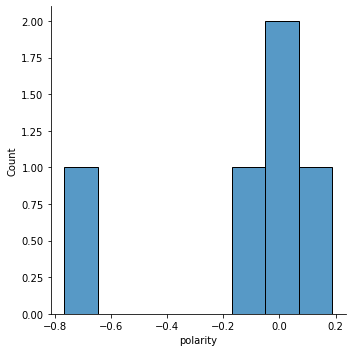

In [21]:
# plot polarity in cfpb_sample using seaborn
sns.displot(cfpb_sample, x="polarity")
plt.show()

What's going on here? Why does sentiment look so close to neutral, or even slightly positive? We know that all of the narratives in this dataset are consumer **complaints**, so we should expect them to look somewhat negative. Let's look at the 5 most positive reviews:

In [22]:
# print the 5 most positive complaints in cfpb_sample
for complaint in cfpb_sample.nlargest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + "\n")

Milestone through Genesis FS card services offered me a settlement in the amount of {$890.00} to settle my account in full of the payment was posted by XX/XX/2022. I called prior to the date and on that date again to advise I was posting the payment online. I posted the payment and received confirmation of the payment. 

Recently I received notification from XXXX XXXX XXXX saying they were collecting on it and my balance was {$2300.00}. I disputed it saying I had settled in full and sent them the email confirmation of payment I received. They sent me a response saying I didnt not provide proof. Im not sure what more to provide. I did exactly what Milestone asked and paid the amount in full.

I have a debt on my credit report reporting as opened on XXXX XXXX and reporting a new balance on behalf NetCredit that was closed XX/XX/XXXX from XXXX XXXX XXXX. 
This debt is not owed, in fact this debt was closed because I sent Net Credit an FTC packet along with police report showing Identity t

Do we have any words that are skewing things? Let's look at the sentiment score for this first comment, and the individual sentiments of the words in it:

In [23]:
sample_complaint = "the company said they are offering a covid relief program which I requested assistance and they are saying a balloon payment is owed in XXXX I called the company and I was told that if I can't make this payment they will be talking taking litigation steps how are people who have lost their job able to keep their homes"
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  0.5
the 0.0
company 0.0
said 0.0
they 0.0
are 0.0
offering 0.0
a 0.0
covid 0.0
relief 0.0
program 0.0
which 0.0
I 0.0
requested 0.0
assistance 0.0
and 0.0
they 0.0
are 0.0
saying 0.0
a 0.0
balloon 0.0
payment 0.0
is 0.0
owed 0.0
in 0.0
XXXX 0.0
I 0.0
called 0.0
the 0.0
company 0.0
and 0.0
I 0.0
was 0.0
told 0.0
that 0.0
if 0.0
I 0.0
can't 0.0
make 0.0
this 0.0
payment 0.0
they 0.0
will 0.0
be 0.0
talking 0.0
taking 0.0
litigation 0.0
steps 0.0
how 0.0
are 0.0
people 0.0
who 0.0
have 0.0
lost 0.0
their 0.0
job 0.0
able 0.5
to 0.0
keep 0.0
their 0.0
homes 0.0


Only one word actually has a sentiment score ("able")! TextBlob's sentiment polarity is not a simple average of all of the sentiments in a string - this is why preprocessing is important and why you should validate these types of off-the-shelf methods. Let's take a look at the most negative reviews and see if these make sense:

In [24]:
# print the 5 most negative complaints in cfpb_sample
for complaint in cfpb_sample.nsmallest(5, 'polarity')['Consumer complaint narrative']:
    print(complaint + '\n')

Money is being held with out my permission. Causing me to have pain and suffering for me and my daughter. Horrible customer service and rude employees lie about the policy and does not follow it. I am having a horrible experience with chime and it needs to be resolved.

On XX/XX/XXXX I was seen at the XXXX XXXX  department. On XX/XX/XXXX I received 100 % patient financial services through this hospital. The patient financial services covered all dates of services through XXXX. A debt was sent to collections for this DOS. When I contacted XXXX they were unaware of this debt. Upon further investigation, it was found that the ER physician was contracted through XXXX and sent the bill out. When I contacted the ER physicians company and informed them of the patient financial service  they told me they were unable to help as they had already sold the debt. ( I received no bill from this provider ). The bill would have been 100 % covered under the patient financial services. I was contacted b

In [25]:
sample_complaint = "Navient is the worst company to ever exist. Website does not work. Do the people at customer service even work for navient??? They don't know anything about whats going on. Applied for a repayement plan and their website always says an error has occured."
print("overall polarity score is ", TextBlob(sample_complaint).sentiment.polarity)
for word in sample_complaint.split():
    print(word, TextBlob(word).sentiment.polarity)

overall polarity score is  -1.0
Navient 0.0
is 0.0
the 0.0
worst -1.0
company 0.0
to 0.0
ever 0.0
exist. 0.0
Website 0.0
does 0.0
not 0.0
work. 0.0
Do 0.0
the 0.0
people 0.0
at 0.0
customer 0.0
service 0.0
even 0.0
work 0.0
for 0.0
navient??? 0.0
They 0.0
don't 0.0
know 0.0
anything 0.0
about 0.0
whats 0.0
going 0.0
on. 0.0
Applied 0.0
for 0.0
a 0.0
repayement 0.0
plan 0.0
and 0.0
their 0.0
website 0.0
always 0.0
says 0.0
an 0.0
error 0.0
has 0.0
occured. 0.0


In this case we have a perfectly negative sentiment (-1.0), but again only one word is contirbuting - "worst". Sentiment polarity is a powerful tool, but not automatically suited to inference. That being said, maybe it can be helpful for distinguishing between labels. We can take a look at how polarity differs across mortgage and student loans:

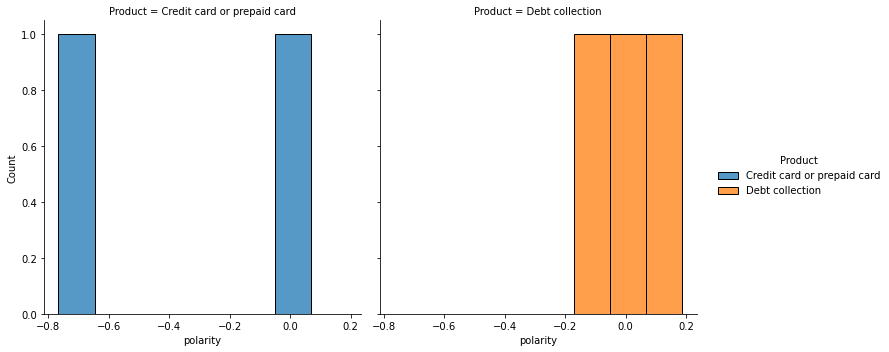

In [26]:
# plot polarity in cfpb_sample by Product
sns.displot(cfpb_sample, x="polarity", hue = "Product", col = "Product")
plt.show()

### Challenge

In addition to sentiment polarity, TextBlob also has a method for determining how "objective" or "subjective" a piece of text is. Plot the objectivity measure by Product. Do these results make sense?

<ipython-input-27-befb9952ab6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfpb_sample['subjectivity'] = cfpb_sample['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


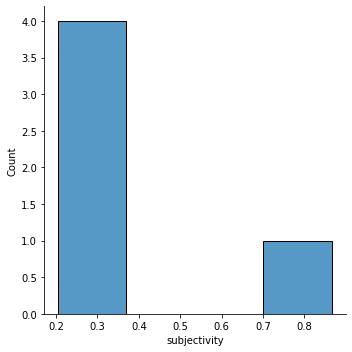

In [27]:
# calculate subjectivity using TextBlob for each complaint in cfpb_sample and save as a column 'subjectivity'
cfpb_sample['subjectivity'] = cfpb_sample['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
# plot subjectivity in cfpb_sample
sns.displot(cfpb_sample, x="subjectivity")
plt.show()

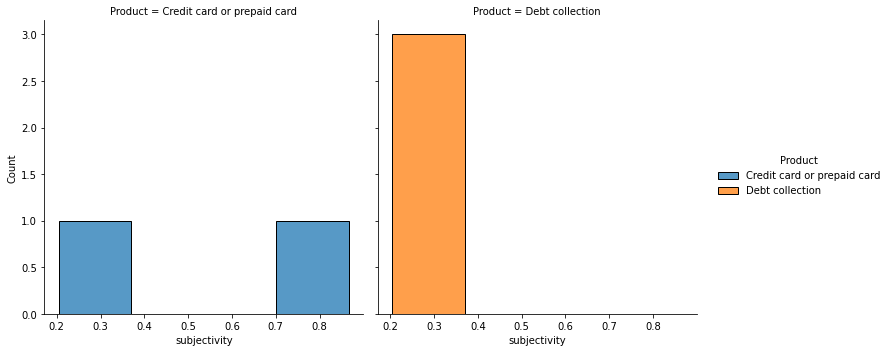

In [28]:
# plot subjectivity in cfpb_sample by Product
sns.displot(cfpb_sample, x="subjectivity", hue = "Product", col = "Product")
plt.show()

# Step 3: Supervised Machine Learning

## Basic Machine Learning Workflow in sklearn

We are almost ready to start making some predictions! We already saw unsupervised learning, and now we will do some supervised learning to predict the "Product category." Supervised learning can be divided into `regression` and `classification`. Regression is used to predict continuous outcomes, while classification is used to predict discrete ones.

One difference between machine learning and other types of empirical legal studies is the use of `data splitting`. We always split our data into `train` and `test` sets. The model learns on the train set, then we make predictions in the test set to see how well the model does. Why don't we use the whole dataset at once? 

The most popular Python machine learning library is `sklearn`. Now that we have featurized our text, we are ready to start predicting Product categories. The general steps for training and validating a machine learning model is:

1. Split the data into "train" and "test" sets. The model will train on the first, then make predictions on the second.
2. Select a model, and specify its `hyperparameters`
3. Evaluate its performance

Models tend to **overfit** their training data, and perform worse when making predictions on new data. So we use our test set to to evaluate how well our model will do out-of-sample.

<center>
    <img src = 'images/overfitting.png'/>
</center>

*Source*: AWS

Luckily, sklearn makes this split easy:

In [29]:
# Take cfpb, turn the 'Product' column into a target variable and binarize, then use the tf_idf matrix as the feature matrix, and split the data into training and testing sets
"""
X = tfidf_vector.fit_transform(cfpb['Consumer complaint narrative'])

# save X to a pickle in data folder
import pickle
with open('data/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
"""

import pickle
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

y = cfpb['Product'].map(lambda x: 1 if x == 'Debt collection' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

We can then train our first machine learning model. We'll start with something you may have seen before, the logistic regression:

In [30]:
# train a logistic regression to predict y_train with default hyperparameters
## import LogisticRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression
## initialize LogisticRegression and save as lr
lr = LogisticRegression()
## fit lr to X_train and y_train
lr.fit(X_train, y_train)
## predict y_test from X_test and save as y_pred
y_pred = lr.predict(X_test)

### Evaluation Metrics

Now we can evaluate how well we did.

In machine learning, there are several metrics we might care about. **Accuracy** is an expression of ratio of correct observations relative to incorrect observations. But accuracy isn't the only metric that we might care about. But there are other metrics we might care about, like **Recall** and **Precision**. The basic building blocks for evaluation metrics are:

$$
True \space Positives = \sum({Predicted \space Positives = Observed \space Positives})
$$

$$
False \space Positives = \sum({Predicted \space Positives \space != Observed \space Positives})
$$

$$
True \space Negatives = \sum({Predicted \space Negatives = Observed \space Negatives})
$$

$$
False \space Negatives = \sum({Predicted \space Negatives \space != Observed \space Negatives})
$$

These can be combined into other metrics. For example:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

$$
Precision = \frac{TP}{TP + FP}
$$

$$
Recall = \frac{TP}{TP + FN}
$$

$$
F1 = 2 * \frac{precision * recall}{precision + recall}
$$


One basic tool for evaluating our classifier is the **confusion matrix**. Values along the diagonal are true positives. How can we intuit other metrics like precision and recall from looking at a plot like this?

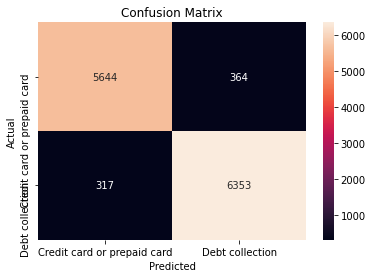

In [31]:
# create y_test and then create a confusion matrix for y_pred and y_test
confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix and name the axes 'Debt collection', 'Credit card or prepaid card' and 'Predicted', 'Actual'. Don't use scientific notation
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
ax.yaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
plt.show()

## Hyperparameter Grid Search

One of the major differences between machine learning and other types of empirical work is that we usually don't pick just one model to run. Instead, we search for the best model, optimizing on a metric like accuracy, and vary the **hyperparameters**. Notice in our logistic regression earlier we initialized it without any arguments. However, if we look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), there are several options, including for **regularization**. Remember, one of the issues with machine learning algorithms is that they tend to overfit the training data. Regularization adds a penalty to curb this behavior. The three common options are L1, L2, and Elastic Net. 

$$
L1 = \lambda\sum_{j=1}^n|\theta_j|
$$

$$
L2 = \lambda\sum_{j=1}^n\theta_j^2
$$

$$
ElasticNet = \alpha\sum_{j=1}^n|\theta_j| + (1 - \alpha)\sum_{j=1}^n\theta_j^2
$$

At a high level, each of these provides methods for automatic **feature selection**. L1 (or Lasso) will drop the coefficients on unimportant features to 0, L2 (or Ridge) will shrink features toward 0, and Elastic Net combines the two. Before we see how this works in practice, let's introduce one last concept. Earlier we split our data into train/test by a 80/20 ratio. Another way to do train/test splits is with **cross validation.** The basic intuition is that we split our data into a number of "folds", then each fold is further split into a number of train folds and a test fold. We train in each train fold, then test on the test fold. Then we rotate and another fold becomes the "test" fold and we train and test again. We then average across all of the folds. The main advantage of this approach is that it allows every data point to be in both the train and test sets, and tends to reduce overfitting.

<center>
    <img source='images/cross validation.png'/>
</center>

c:\Users\Anike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Anike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'C': 2.782559402207126, 'penalty': 'l2'}
0.9485445718789455


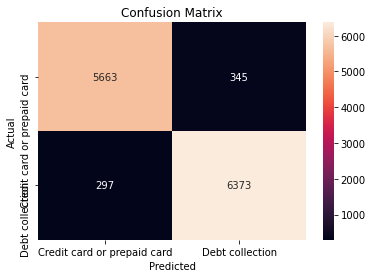

In [32]:
# create a hyperparameter grid for logistic regression checking L1, L2, and Elastic Net regularization and 10 values of C
param_grid = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': np.logspace(-4, 4, 10)}

# import GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# initialize GridSearchCV with the logistic regression, the hyperparameter grid, and 5-fold cross validation
grid = GridSearchCV(lr, param_grid, cv=5)

# fit grid to X_train and y_train
grid.fit(X_train, y_train)

# print the best hyperparameters
print(grid.best_params_)

# show the best 5 scores
grid.cv_results_['mean_test_score'][0:5]

# print the best score
print(grid.best_score_)

# save the best estimator as best_lr
best_lr = grid.best_estimator_

# confusion matrix for the best estimator, label the axes 'Prediction' and 'Actual' and 'Credit card or prepaid card' and 'Debt collection'
y_pred = best_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
ax.yaxis.set_ticklabels(['Credit card or prepaid card', 'Debt collection'])
plt.show()

How did our optimal model do compared to the one without any hyperparameters set? 

### Challenge

Try it yourself! Use logistic regression and the `RandomForestClassifier()` and `GradientBoostingClassifier()` methods 

In [ ]:
# create hyperparameter grids for logistic regression, random forest, and gradient boosting
lr_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
rf_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
gb_grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30], 'learning_rate': [0.1, 0.5, 1]}
# import GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV
# initialize GridSearchCV for logistic regression, random forest, and gradient boosting
lr_gs = GridSearchCV(LogisticRegression(), lr_grid)
rf_gs = GridSearchCV(RandomForestClassifier(), rf_grid)
gb_gs = GridSearchCV(GradientBoostingClassifier(), gb_grid)
# fit GridSearchCV for logistic regression, random forest, and gradient boosting
lr_gs.fit(X_train, y_train)
rf_gs.fit(X_train, y_train)
gb_gs.fit(X_train, y_train)
# print the best hyperparameters for logistic regression, random forest, and gradient boosting
print(lr_gs.best_params_)
print(rf_gs.best_params_)
print(gb_gs.best_params_)
# predict y_test from X_test using the best hyperparameters for logistic regression, random forest, and gradient boosting
y_pred_lr = lr_gs.predict(X_test)
y_pred_rf = rf_gs.predict(X_test)
y_pred_gb = gb_gs.predict(X_test)
# create confusion matrices for logistic regression, random forest, and gradient boosting
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_gb = confusion_matrix(y_test, y_pred_gb)
# create heatmaps for logistic regression, random forest, and gradient boosting
sn.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
sn.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
sn.heatmap(cm_gb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# print the accuracy scores for logistic regression, random forest, and gradient boosting
print(lr_gs.score(X_test, y_test))
print(rf_gs.score(X_test, y_test))
print(gb_gs.score(X_test, y_test))
# print the classification reports for logistic regression, random forest, and gradient boosting
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_gb))


# Step 4: Challenge

Do either of the following:

a) Using your own dataset, implement some of the techniques we explored here to featurize text and predict some outcome.

b) Using the CPFB dataset, try running some models that include non-tfidf features. For example, you might use topic weights, sentiment, or objectivity/subjectivity scores. You might also want to include some of the other features in the dataset like whether the complaint was resolved, the issue, and the company involved. We didn't explore how to pre-process categorical data like that for a machine learning pipeline - do you think you could get GPT to show you how to?

# Future Directions

We've covered some basics today, but here are some future steps you might take:

* **Acquiring Data**: Working with web scrapers, APIs etc. to get structured text data.
* **Preprocessing**: We did some basic pre-processing of text data, but there are other factors to consider like creating categorical dummies, scaling certain features, and doing some ex ante feature selection with methods like correlation plots.
* **Word Embeddings**: We covered using basic tokenization and featurization using word counts but other methods like word2vec and transformers can be used to capture context and word meaning.
* **Regression**: We did a bit of classification, but some problems will require that you predict a continuous target and there are different techniques and metrics to go with this.
* **Deep Learning**: We covered some basic classification algorithms, but neural nets are a powerful tool for making better classifications, especially with complex data like text or images.
* **AutoML**: In practice, machine learning requires running hundreds or thousands of models to find the best one. AutoML libraries such as TPOT can help automate the process searching for the best model.